In [3]:
from datasets import load_dataset, load_from_disk, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from hashlib import sha256
import requests
from io import BytesIO
from tqdm import tqdm
from collections import defaultdict
import json
import os
import random
import math
%matplotlib inline

def plot(img, points=None):
    plt.imshow(img)
    if points:
        for p in points:
            plt.scatter(p[0], p[1], color='red', s=10)
    plt.axis('off')
    plt.show()

def plot_masked_image(img: Image.Image, mask: np.ndarray):
    """
    Display only the parts of `img` where `mask` is True.
    Parameters:
    - img: PIL.Image of size (w, h) or (h, w)
    - mask: 2D boolean numpy array of shape (h, w)
    """
    # Ensure image has an alpha channel
    img_rgba = img.convert("RGBA")
    arr = np.array(img_rgba)

    # Set alpha to 255 where mask=True, 0 otherwise
    arr[..., 3] = mask.astype(np.uint8) * 255

    # Convert back and plot
    masked_img = Image.fromarray(arr)
    plt.figure(figsize=(6, 6))
    plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

def url2img(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

def denorm(x,y,w,h):
  x = (x/100) * w
  y = (x/100) * h
  return x,y


### num_bbox: num_images

In [6]:
""" 
For pointing subset:
    num unique images = 155k
    bbox per image : num_images  = {
        0: 280k
        1: 1.2M
        2: 235k
        3: 100k
        4: 80k
        5: 40k
        6: 30k....
    }

    one_bbox, pointing subset: 1.2M images, 152k unique images

    1. train all 1.1 images (best)
    3. sample 150k random images (suboptimal) 
    2. train 150k unique images and sample:
        a. k random bboxes
        b. k largest bboxes

write code : unique image --> bboxes (a or b)
for each 80k images of pixmo --> 80k images of refCOCOg (higher quality)
"""

' \nFor pointing subset:\n    num unique images = 155k\n    bbox per image : num_images  = {\n        0: 280k\n        1: 1.2M\n        2: 235k\n        3: 100k\n        4: 80k\n        5: 40k\n        6: 30k....\n    }\n\n    one_bbox, pointing subset: 1.2M images, 152k unique images\n\n    1. train all 1.1 images (best)\n    3. sample 150k random images (suboptimal) \n    2. train 150k unique images and sample:\n        a. k random bboxes\n        b. k largest bboxes\n\nwrite code : unique image --> bboxes (a or b)\nfor each 80k images of pixmo --> 80k images of refCOCOg (higher quality)\n'

# Pointing subset DataFrame (2M samples)
data = /pixmo-train
image_dir = /pixmo_images

In [ ]:
# data = load_dataset("allenai/pixmo-points")['train']
# df = data.to_pandas()
# df.head(3)


# pixmoid2url = dict(zip(list(df.pixmo_id),list(df.image_url) ))
# import pickle
# with open("/storage/users/manugaur/mllm_inversion/pixmo/pixmoid2url.pkl", "wb") as f:
#     pickle.dump(pixmoid2url, f)

In [ ]:
# url2pixmoID = {}
# counter = 0
# for url in list(df.image_url):
#     if url not in url2pixmoID:
#         url2pixmoID[url] = F"pixmo{counter}"
#         counter+=1
#     else:
#         continue
# pixmoID = [url2pixmoID[url] for url in list(df['image_url'])] #new column
# df["pixmo_id"] = pixmoID
## df.to_csv("/storage/users/manugaur/mllm_inversion/pixmo/pixmo-train.csv")
## Dataset.from_pandas(df).save_to_disk("/storage/users/manugaur/mllm_inversion/pixmo/pixmo-train")

In [7]:
data = load_from_disk("/storage/users/manugaur/mllm_inversion/pixmo/pixmo-train")
df = data.to_pandas()
df = df[df['collection_method']=="pointing"]
print(f"num image-text pairs : {len(df)}")
df.head(1)

num image-text pairs : 2057090


image_url  \
319132  https://www.greatplacetowork.com/images/profil...   

                                             image_sha256  \
319132  fa55de563cfa9562e9afd78a7921753e1f45895d786ed0...   

                                                   points  count      label  \
319132  [{'x': 91.23325516399498, 'y': 31.635033060150...    NaN  balloons    

       collection_method    pixmo_id  
319132          pointing  pixmo72762

#### save 155k unique img urls to .txt

In [ ]:
# def save_urls_to_file(url_list, filename):
#     with open(filename, 'w') as f:
#         for url in url_list:
#             f.write(f"{url}\n")

# urls = set(list(df.image_url))
# save_urls_to_file(urls, "/storage/users/manugaur/mllm_inversion/pixmo/pointing_155k_unique_urls.txt")

### Viz images


In [152]:
def get_url_list(filename):
    with open(filename, 'r') as file:
        return [line.strip() for line in file if line.strip()]

In [8]:
import os
import pickle
id2url= pickle.load(open("/storage/users/manugaur/mllm_inversion/pixmo/pixmoid2url.pkl", "rb"))
images = os.listdir("/storage/users/manugaur/pixmo_images")
# list(set(get_url_list("/storage/users/manugaur/mllm_inversion/pixmo/pointing_155k_unique_urls.txt")) - set([id2url[i.split(".")[0]] for i in images]))
print(f"number of unique images : {len(images)}")

number of unique images : 142435


### distribution of points_per_img

In [155]:
id2points = defaultdict(int)
for idx in tqdm(range(len(df)), total=len(df)):
    data = df.iloc[idx]
    id2points[data.pixmo_id]+=len(list(data.points))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057090/2057090 [00:33<00:00, 62041.68it/s]


##### number of points per image --> number of images

In [156]:
numpoints2id = defaultdict(list)
for pixmoid, num_points in id2points.items():
    numpoints2id[num_points].append(pixmoid)
numpoints2count = {}
for k,v in numpoints2id.items():
    numpoints2count[k] = len(v)

sorted(numpoints2count.items(), key = lambda x  : x[0])

[(9, 5008),
 (10, 6132),
 (11, 14510),
 (12, 10778),
 (13, 8061),
 (14, 9974),
 (15, 7298),
 (16, 6187),
 (17, 5545),
 (18, 4984),
 (19, 4701),
 (20, 4397),
 (21, 4047),
 (22, 3797),
 (23, 3424),
 (24, 3402),
 (25, 3161),
 (26, 2974),
 (27, 2688),
 (28, 2489),
 (29, 2333),
 (30, 2206),
 (31, 2069),
 (32, 1932),
 (33, 1766),
 (34, 1697),
 (35, 1636),
 (36, 1500),
 (37, 1496),
 (38, 1332),
 (39, 1218),
 (40, 1151),
 (41, 1090),
 (42, 1057),
 (43, 926),
 (44, 908),
 (45, 824),
 (46, 872),
 (47, 747),
 (48, 722),
 (49, 656),
 (50, 636),
 (51, 638),
 (52, 596),
 (53, 531),
 (54, 517),
 (55, 467),
 (56, 464),
 (57, 471),
 (58, 435),
 (59, 413),
 (60, 432),
 (61, 354),
 (62, 351),
 (63, 343),
 (64, 274),
 (65, 244),
 (66, 281),
 (67, 245),
 (68, 271),
 (69, 241),
 (70, 234),
 (71, 215),
 (72, 188),
 (73, 194),
 (74, 199),
 (75, 154),
 (76, 165),
 (77, 144),
 (78, 149),
 (79, 145),
 (80, 134),
 (81, 127),
 (82, 117),
 (83, 130),
 (84, 103),
 (85, 96),
 (86, 88),
 (87, 92),
 (88, 96),
 (89, 87)

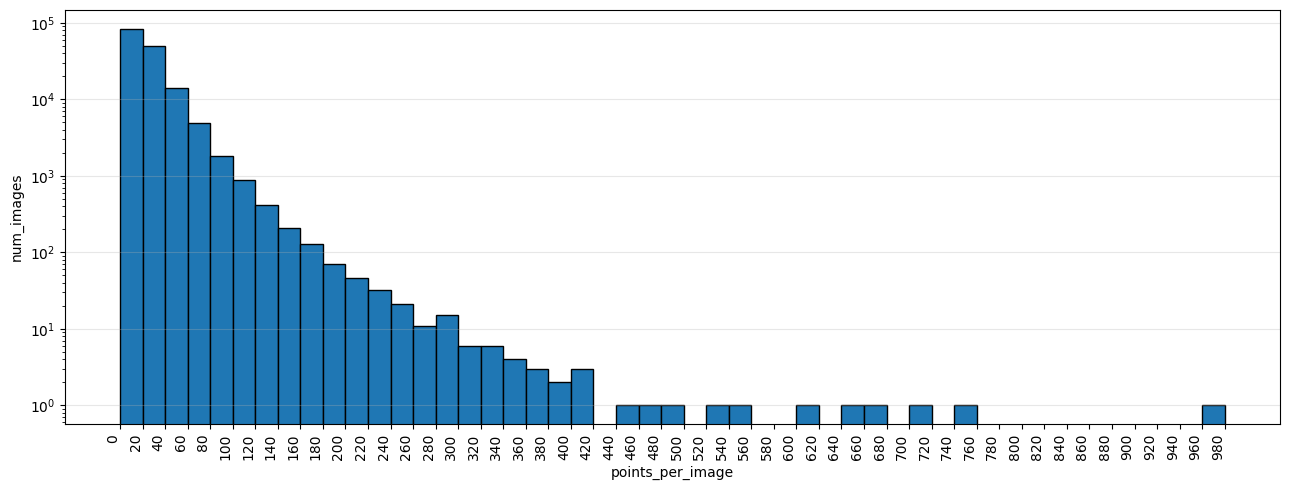

In [142]:
import matplotlib.pyplot as plt
import numpy as np


attribute = np.array(list(id2points.values()))
bin_size = 20
bins = np.arange(0, max(attribute) + bin_size, bin_size)

# plot
plt.figure(figsize=(13,5))
plt.hist(attribute, bins=bins, edgecolor='black')  # edgecolor to separate bars clearly
plt.yscale('log')
plt.xlabel('points_per_image')
plt.ylabel('num_images')
plt.xticks(bins, rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [157]:
# for i in range(100):
# sampled_pixmoid = random.sample(images, 1)[0].split(".")[0]
# pixmo133846 --> 84
# pixmo80436 --> 12
# pixmo226802 --> 26
# pixmo159461 --> 53
sampled_pixmoid = "pixmo80436"
data_chunk = df[df['pixmo_id']==sampled_pixmoid]
c = 0
for points in list(data_chunk.points):
    for p in points:
        c+=1
# print(f"{sampled_pixmoid} --> {c}")
# print(f'this image has {c} points')


cabbage head | 1 points


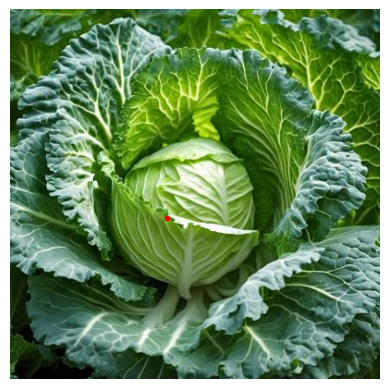

cabbage leaves | 1 points


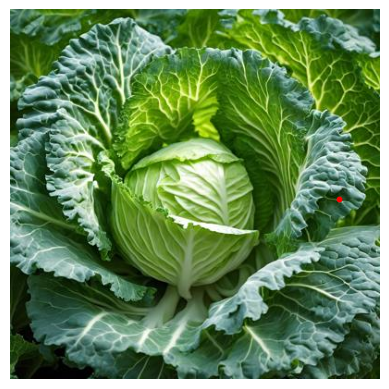

dark green outer edges of cabbage | 1 points


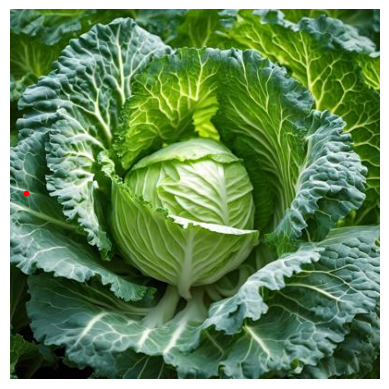

light green color of cabbage head | 1 points


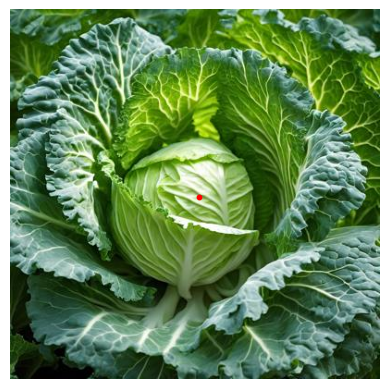

kelly green color of cabbage leaf | 1 points


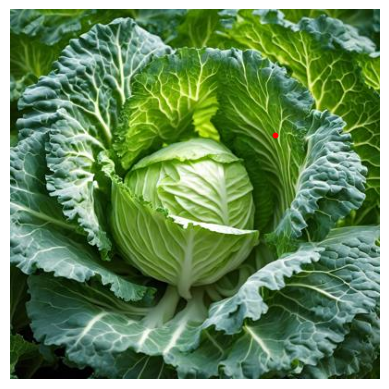

cabbage stalk | 1 points


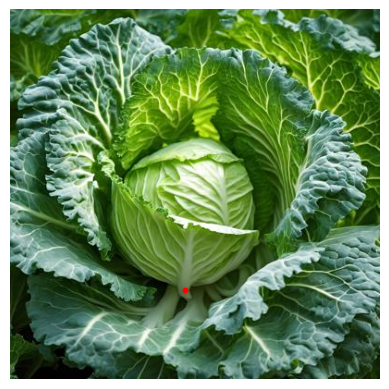

the ground surrounding the cabbage | 0 points


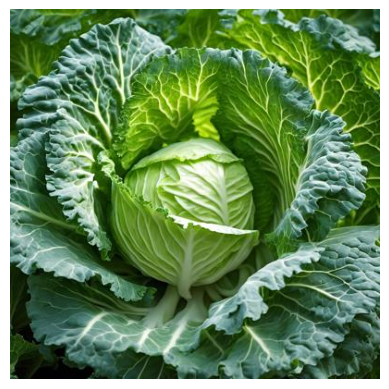

a person to pick the cabbage | 0 points


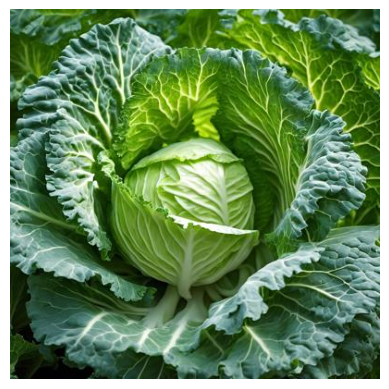

veins of the cabbage | 1 points


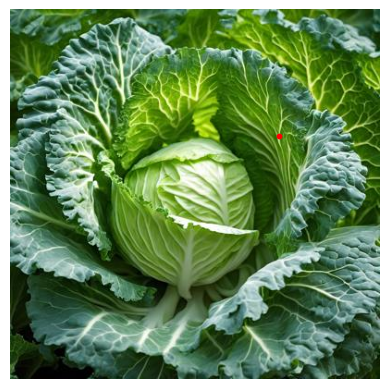

white color of cabbage stalk | 1 points


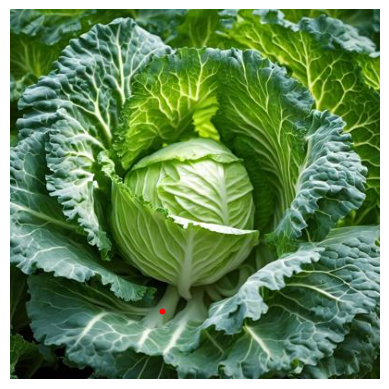

the type of soil the cabbage was planted in | 0 points


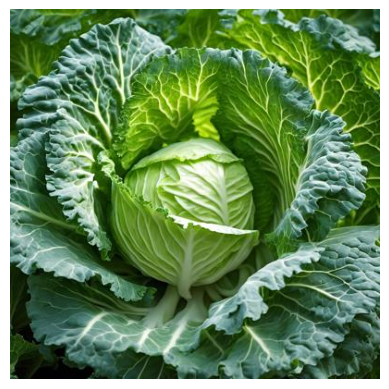

frilled flowing pattern of cabbage leaves | 1 points


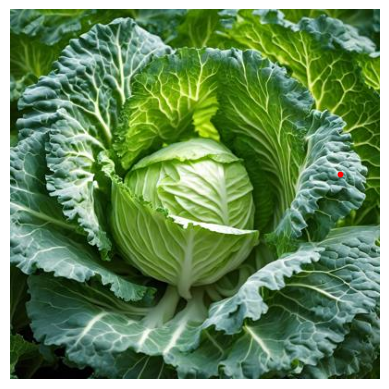

cabbage core | 1 points


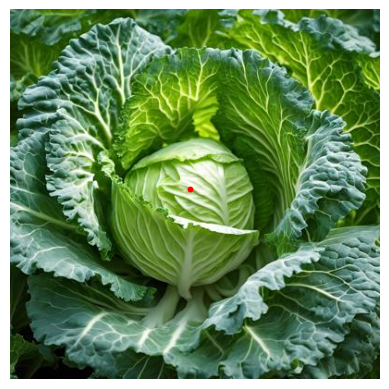

cabbage leaf appearing as tree | 1 points


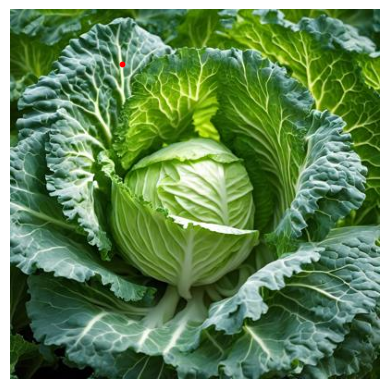

cabbage leaf in background appearing like grass | 1 points


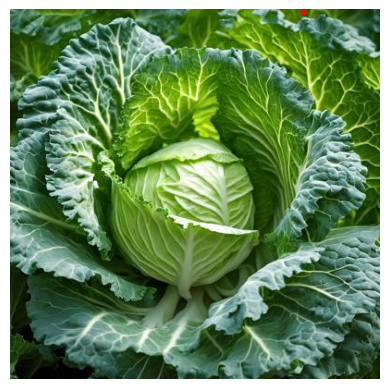

In [158]:
image_url = data_chunk.iloc[0]['image_url']
img = url2img(image_url)
w,h = img.size

for idx in range(len(data_chunk)):
    data = data_chunk.iloc[idx]
    num_points = len(data['points'])
    print(data['label'], f"| {num_points} points")
    points  = [((p['x']*w)/100, (p['y']*h)/100) for p in data['points']]
    plot(img, points)

white "a" watermark | 23 points


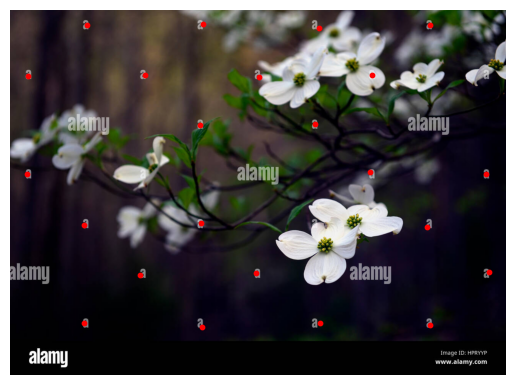

In [149]:
image_url = data_chunk.iloc[0]['image_url']
img = url2img(image_url)
w,h = img.size

for idx in range(len(data_chunk)):
    data = data_chunk.iloc[idx]
    num_points = len(data['points'])
    print(data['label'], f"| {num_points} points")
    points  = [((p['x']*w)/100, (p['y']*h)/100) for p in data['points']]
    plot(img, points)
    break

In [ ]:
image_url = data_chunk.iloc[0]['image_url']
for idx in range(len(data_chunk)):
    data = data_chunk.iloc[idx]

    print(data['label'])
    img = url2img(image_url)
    w,h = img.size
    print(f"image w,h : {w,h}")

    num_points = len(data['points'])
    for _ in range(num_points):
        x,y = data['points'][_].values()
        x = (x/100) * w
        y = (y/100) * h
        plot(img, ((x,y)))
    print(f"---"*100)

In [ ]:
image_url = data_chunk.iloc[0]['image_url']
for idx in range(len(data_)):
    data = data_chunk.iloc[idx]

    print(data['label'])
    img = url2img(image_url)
    w,h = img.size
    print(f"image w,h : {w,h}")

    num_points = len(data['points'])
    for _ in range(num_points):
        x,y = data['points'][_].values()
        x = (x/100) * w
        y = (y/100) * h
        plot(img, ((x,y)))
    print(f"---"*100)


In [ ]:
# with open("/storage/users/manugaur/mllm_inversion/pixmo/dataids_pointing_onebbox.json", "w") as f:
#     json.dump(ids_1bbox, f)
data_pointing_onebbox = data_dict.select(ids_1bbox)

In [ ]:
# data_pointing_onebbox.save_to_disk("/storage/users/manugaur/mllm_inversion/pixmo/pointing_onebbox/")
data_dict = data_pointing_onebbox

unique_images = set()

for idx,  data in tqdm(enumerate(data_dict), total = len(data_dict)):
    unique_images.add(data['image_url'])

print(f"unique images in pointing split with one_bbox per img: {len(unique_images)}")

# with open("/storage/users/manugaur/mllm_inversion/pixmo/150k_unique_images.json", "w") as f:
#     json.dump(list(unique_images), f)

#### download 150k unique images

In [ ]:
""" 
Pixmo Data Distribution 
- get unique img --> bbox code ready

do images have multiple same objects???
mixed signal? learning to localize different objects every time?

MAKE SURE LABELS ARE DIFFERENT


"""

## visualizing images

In [ ]:

for idx in range(10):
    data = data_dict[idx]

    print(data['label'])
    # uid= data['image_sha256']
    # masks = data['masks']

    img = url2img(data['image_url'])
    w,h = img.size
    print(f"image w,h : {w,h}")

    num_points = len(data['points'])
    for _ in range(num_points):
        x,y = data['points'][_].values()
        x = (x/100) * w
        y = (y/100) * h
        plot(img, ((x,y)))
        # mask = np.array(masks[_])
        # plot_masked_image(img, mask)
    print(f"---"*100)


In [ ]:
np.array(masks[0]).shape

In [ ]:
print(len(data_dict[0]['masks']))
mask = data_dict[0]['masks']
len(mask[0]) #list of list | first list = num_points i presume, second list = 1024 boolean

In [ ]:
image_bytes = requests.get(data["image_url"]).content
byte_hash = sha256(image_bytes).hexdigest()
# assert byte_hash == data["image_sha256"]
print(byte_hash)
plot_url(data['image_url'])

In [ ]:
data['image_sha256']